In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import shutil


def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# Define paths to your dataset
base_dir = "/content/drive/MyDrive/dataset"
normal_dir = os.path.join(base_dir, 'normal')
alzheimers_dir = os.path.join(base_dir, 'alzheimers_dataset')
parkinsons_dir = os.path.join(base_dir, 'parkinsons_dataset')
glioma_dir=os.path.join(base_dir,'glioma')
meningioma=os.path.join(base_dir,'meningioma')
output_base_dir = "/content/drive/MyDrive/dataset"
train_dir = os.path.join(output_base_dir, 'train')
val_dir = os.path.join(output_base_dir, 'validation')
test_dir = os.path.join(output_base_dir, 'test')

for category in ['Normal', 'Alzheimers', 'Parkinson','Glioma','Meningioma']:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)


In [3]:
def preprocess_images(SOURCE, DEST, target_size=(224, 224)):
    for filename in os.listdir(SOURCE):
        img_path = os.path.join(SOURCE, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, target_size)
            img = img / 255.0  # Normalize to [0, 1]
            dest_img_path = os.path.join(DEST, filename)
            cv2.imwrite(dest_img_path, img * 255)

In [4]:
def split_data(SOURCE, TRAINING, VALIDATION, TEST, SPLIT_SIZE=0.8, VALID_SIZE=0.1, TEST_SIZE=0.1):
    all_files = []
    for file_name in os.listdir(SOURCE):
        file_path = os.path.join(SOURCE, file_name)
        if os.path.getsize(file_path) > 0:
            all_files.append(file_name)
        else:
            print(f'{file_name} is zero length, so ignoring.')

    train_set, temp_set = train_test_split(all_files, test_size=1-SPLIT_SIZE)
    valid_set, test_set = train_test_split(temp_set, test_size=TEST_SIZE/(TEST_SIZE + VALID_SIZE))
    for file_name in train_set:
        copy_file(file_name, SOURCE, TRAINING)

    for file_name in valid_set:
        copy_file(file_name, SOURCE, VALIDATION)

    for file_name in test_set:
        copy_file(file_name, SOURCE, TEST)

In [5]:
def copy_file(file_name, src_dir, dest_dir):
    src = os.path.join(src_dir, file_name)
    dest = os.path.join(dest_dir, file_name)
    shutil.copyfile(src, dest)

In [6]:
import matplotlib.pyplot as plt
# Visualize some images
def visualize_images(category, source_dir, num_images=5):
    plt.figure(figsize=(15, 5))
    for i, filename in enumerate(os.listdir(source_dir)[:num_images]):
        img_path = os.path.join(source_dir, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, num_images, i+1)
            plt.imshow(img)
            plt.title(f"{category} - {i+1}")
            plt.axis('off')
    plt.show()

Visualizing images from Normal


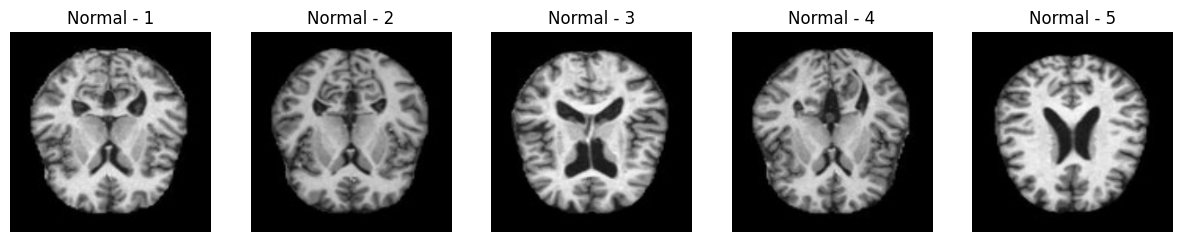

Visualizing images from Alzheimers


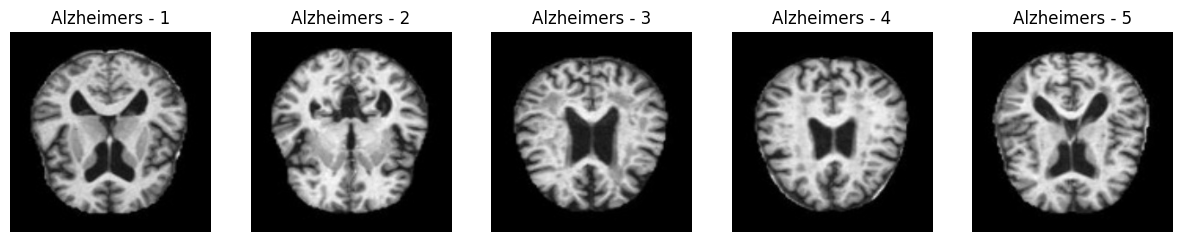

Visualizing images from Parkinson


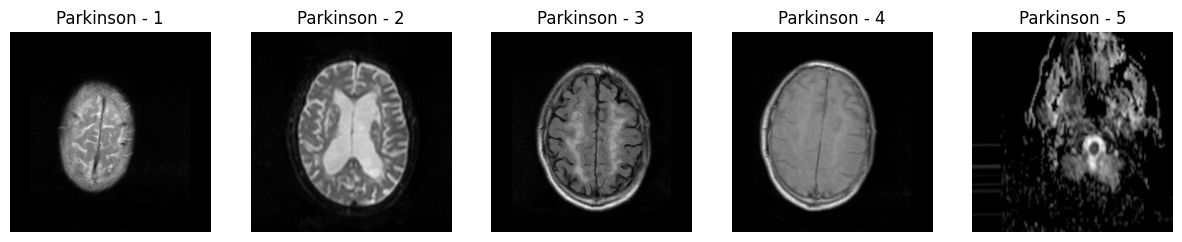

Visualizing images from Glioma


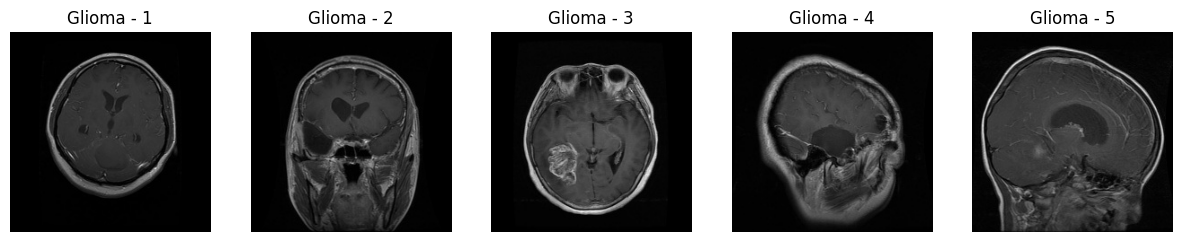

Visualizing images from Meningioma


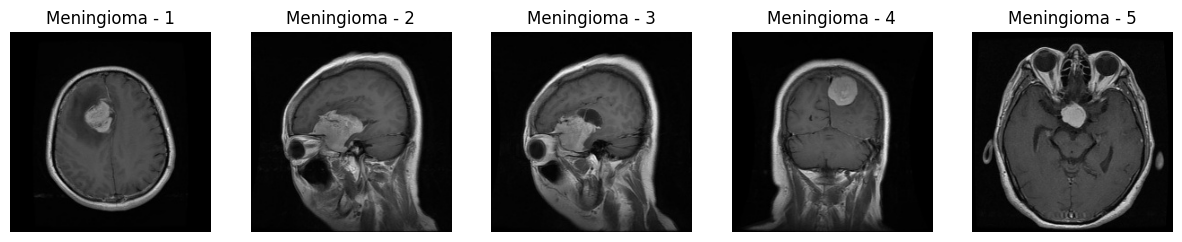

Data preprocessing and splitting completed.


In [7]:
for category, source_dir in [('Normal', normal_dir), ('Alzheimers', alzheimers_dir), ('Parkinson', parkinsons_dir),('Glioma',glioma_dir),('Meningioma',meningioma)]:
    train_dest = os.path.join(train_dir, category)
    val_dest = os.path.join(val_dir, category)
    test_dest = os.path.join(test_dir, category)

    split_data(source_dir, train_dest, val_dest, test_dest)
    preprocess_images(train_dest, train_dest)
    preprocess_images(val_dest, val_dest)
    preprocess_images(test_dest, test_dest)

    # Visualize sample images
    print(f"Visualizing images from {category}")
    visualize_images(category, train_dest)

print("Data preprocessing and splitting completed.")

In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to the processed data directories
train_dir = '/content/drive/MyDrive/dataset/train'
val_dir = '/content/drive/MyDrive/dataset/validation'
test_dir = '/content/drive/MyDrive/dataset/test'

# --- Data Preprocessing ---
# Data Transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load datasets
datasets_dict = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, transform=data_transforms['val']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

# Create DataLoaders
dataloaders = {
    'train': DataLoader(datasets_dict['train'], batch_size=32, shuffle=True),
    'val': DataLoader(datasets_dict['val'], batch_size=32, shuffle=False),
    'test': DataLoader(datasets_dict['test'], batch_size=32, shuffle=False)
}

# Class Names
class_names = datasets_dict['train'].classes
num_classes = len(class_names)
print(f"Classes: {class_names}")

# --- Training Loop for Multiple Runs ---
num_runs = 5
num_epochs = 20
results = []  # To store test accuracies for each run
history_list = []  # To store loss history for each run

for run in range(1, num_runs + 1):
    print(f"\n--- Training Run {run} ---")

    # Initialize the model
    model = models.googlenet(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.to(device)

    # Define Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Initialize tracking variables
    best_model_wts = None
    best_val_accuracy = 0.0
    train_loss_history, val_loss_history = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(datasets_dict[phase])
            epoch_acc = running_corrects.double() / len(datasets_dict[phase])

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'val' and epoch_acc > best_val_accuracy:
                best_val_accuracy = epoch_acc
                best_model_wts = model.state_dict()

            if phase == 'train':
                train_loss_history.append(epoch_loss)
            else:
                val_loss_history.append(epoch_loss)

    # Save the best model of this run
    torch.save(best_model_wts, f"googlenet_run_{run}.pth")

    # Test the model
    model.load_state_dict(best_model_wts)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate test accuracy
    test_accuracy = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
    results.append(test_accuracy)
    print(f"Run {run}: Test Accuracy = {test_accuracy:.2f}%")

    # Save history
    history_list.append((train_loss_history, val_loss_history))

    # Plot Loss Curves for the Run
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Validation Loss")
    plt.title(f"Training and Validation Loss - Run {run}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"training_loss_run_{run}.png")
    plt.close()

# --- Summary of All Runs ---
print("\nSummary of All Runs:")
for run, accuracy in enumerate(results, 1):
    print(f"Run {run}: Test Accuracy = {accuracy:.2f}%")

mean_accuracy = np.mean(results)
std_deviation = np.std(results)
print(f"\nMean Test Accuracy: {mean_accuracy:.2f}%")
print(f"Standard Deviation of Test Accuracy: {std_deviation:.2f}%")

Using device: cuda
Classes: ['Alzheimers', 'Glioma', 'Meningioma', 'Normal', 'Parkinson']

--- Training Run 1 ---


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 158MB/s]



Epoch 1/20
--------------------
Train Loss: 0.4748 Acc: 0.8265
Val Loss: 0.3381 Acc: 0.8788

Epoch 2/20
--------------------
Train Loss: 0.2402 Acc: 0.9011
Val Loss: 0.3584 Acc: 0.8288

Epoch 3/20
--------------------
Train Loss: 0.1715 Acc: 0.9326
Val Loss: 0.1814 Acc: 0.9321

Epoch 4/20
--------------------
Train Loss: 0.1666 Acc: 0.9297
Val Loss: 0.1420 Acc: 0.9467

Epoch 5/20
--------------------
Train Loss: 0.1239 Acc: 0.9479
Val Loss: 0.1212 Acc: 0.9612

Epoch 6/20
--------------------
Train Loss: 0.1120 Acc: 0.9556
Val Loss: 0.0997 Acc: 0.9564

Epoch 7/20
--------------------
Train Loss: 0.0928 Acc: 0.9645
Val Loss: 0.0929 Acc: 0.9661

Epoch 8/20
--------------------
Train Loss: 0.0715 Acc: 0.9731
Val Loss: 0.1667 Acc: 0.9435

Epoch 9/20
--------------------
Train Loss: 0.0738 Acc: 0.9725
Val Loss: 0.0641 Acc: 0.9806

Epoch 10/20
--------------------
Train Loss: 0.0675 Acc: 0.9735
Val Loss: 0.0774 Acc: 0.9758

Epoch 11/20
--------------------
Train Loss: 0.0665 Acc: 0.9735
Val 

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to the processed data directories
train_dir = '/content/drive/MyDrive/dataset/train'
val_dir = '/content/drive/MyDrive/dataset/validation'
test_dir = '/content/drive/MyDrive/dataset/test'

# Data Transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Datasets and Dataloaders
datasets_dict = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, transform=data_transforms['val']),
    'test': datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

dataloaders = {
    'train': DataLoader(datasets_dict['train'], batch_size=32, shuffle=True),
    'val': DataLoader(datasets_dict['val'], batch_size=32, shuffle=False),
    'test': DataLoader(datasets_dict['test'], batch_size=32, shuffle=False)
}

# Print dataset information (number of images in each dataset)
print(f"Found {len(datasets_dict['train'].imgs)} images belonging to {len(datasets_dict['train'].classes)} classes.")
print(f"Found {len(datasets_dict['val'].imgs)} images belonging to {len(datasets_dict['val'].classes)} classes.")
print(f"Found {len(datasets_dict['test'].imgs)} images belonging to {len(datasets_dict['test'].classes)} classes.\n")


Using device: cuda
Found 4952 images belonging to 5 classes.
Found 619 images belonging to 5 classes.
Found 621 images belonging to 5 classes.



In [10]:
import torch
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd

# Assuming the model and DataLoader are already defined, and test_loader is your DataLoader for the test set
# Set model to evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Collect predictions and true labels
with torch.no_grad():  # Disable gradient calculation during inference
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())  # Move predictions to CPU and add to list
        all_labels.extend(labels.cpu().numpy())  # Move labels to CPU and add to list

# Calculate the classification report
report = classification_report(all_labels, all_preds, target_names=dataloaders['test'].dataset.classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()


# Calculate the standard deviation for each class
std_devs = {}
for label in dataloaders['test'].dataset.classes:  # Change test_loader to dataloaders['test']
    # Get indices for each class
    class_indices = np.where(np.array(all_labels) == dataloaders['test'].dataset.class_to_idx[label])[0]  # Change test_loader to dataloaders['test']
    class_predictions = np.array(all_preds)[class_indices]
    std_dev = np.std(class_predictions)
    std_devs[label] = std_dev


# Add standard deviation column to the classification report DataFrame
report_df['std'] = report_df.index.map(std_devs).fillna(0)

# Print the classification report with standard deviation
print("\nClassification Report with Standard Deviation:")
print(report_df)


Classification Report with Standard Deviation:
              precision    recall  f1-score     support       std
Alzheimers     0.960000  0.979592  0.969697  196.000000  0.424176
Glioma         0.993750  0.975460  0.984520  163.000000  0.268821
Meningioma     0.982143  0.993976  0.988024  166.000000  0.077381
Normal         0.947368  0.900000  0.923077   80.000000  0.900000
Parkinson      0.941176  1.000000  0.969697   16.000000  0.000000
accuracy       0.972625  0.972625  0.972625    0.972625  0.000000
macro avg      0.964888  0.969806  0.967003  621.000000  0.000000
weighted avg   0.972665  0.972625  0.972481  621.000000  0.000000


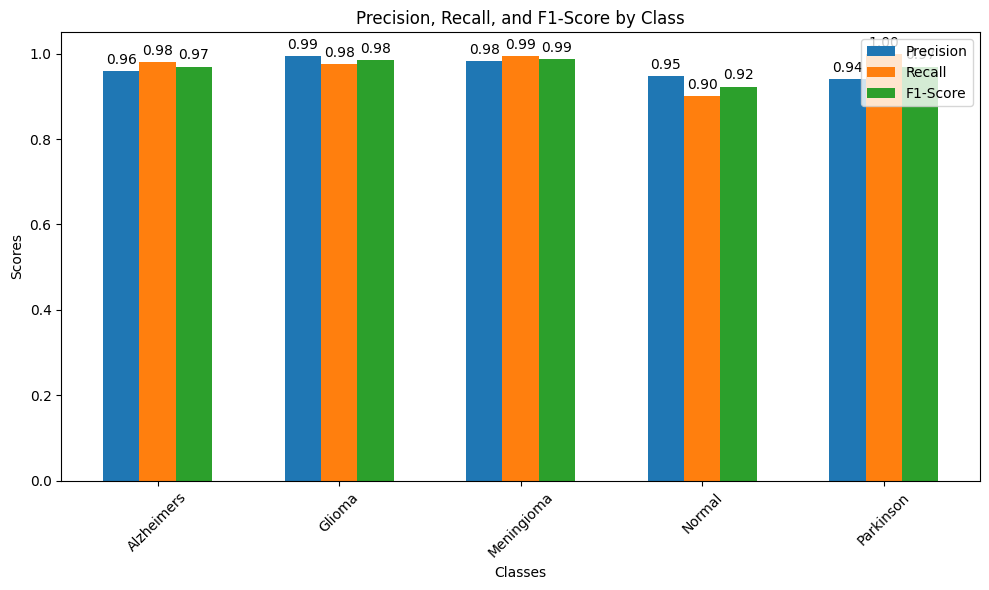

In [11]:
#Extract precision, recall, and f1-score from the classification report DataFrame
metrics = ['precision', 'recall', 'f1-score']
class_names = dataloaders['test'].dataset.classes # Changed test_loader to dataloaders['test']

# Plot grouped bar chart for precision, recall, and f1-score
report_df = pd.DataFrame(report).transpose()
values = report_df.loc[class_names, metrics].values

# Plotting
x = np.arange(len(class_names))  # Class labels
width = 0.2  # Width of each bar

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for precision, recall, and f1-score
rects1 = ax.bar(x - width, values[:, 0], width, label='Precision')
rects2 = ax.bar(x, values[:, 1], width, label='Recall')
rects3 = ax.bar(x + width, values[:, 2], width, label='F1-Score')

# Add labels, title, and legend
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score by Class')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45)
ax.legend()

# Add value labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

plt.tight_layout()
plt.show()

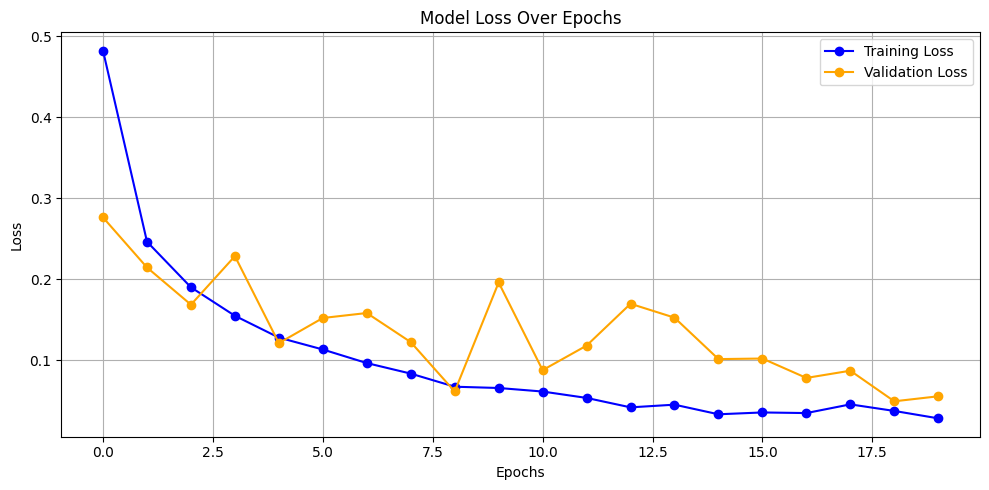

In [12]:
#Convert tensors to CPU and NumPy if needed
train_loss_history = train_loss_history.cpu().numpy() if isinstance(train_loss_history, torch.Tensor) else train_loss_history
val_loss_history = val_loss_history.cpu().numpy() if isinstance(val_loss_history, torch.Tensor) else val_loss_history

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss', marker='o', color='blue')
plt.plot(val_loss_history, label='Validation Loss', marker='o', color='orange')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

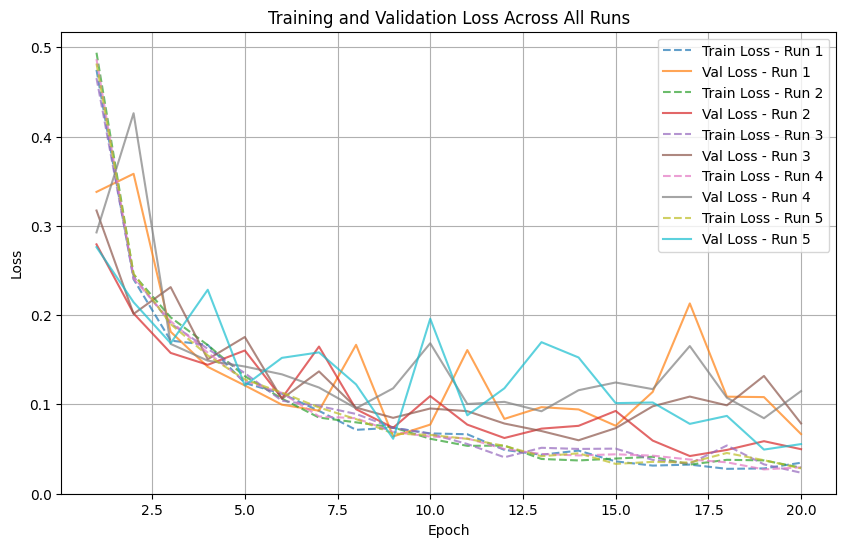

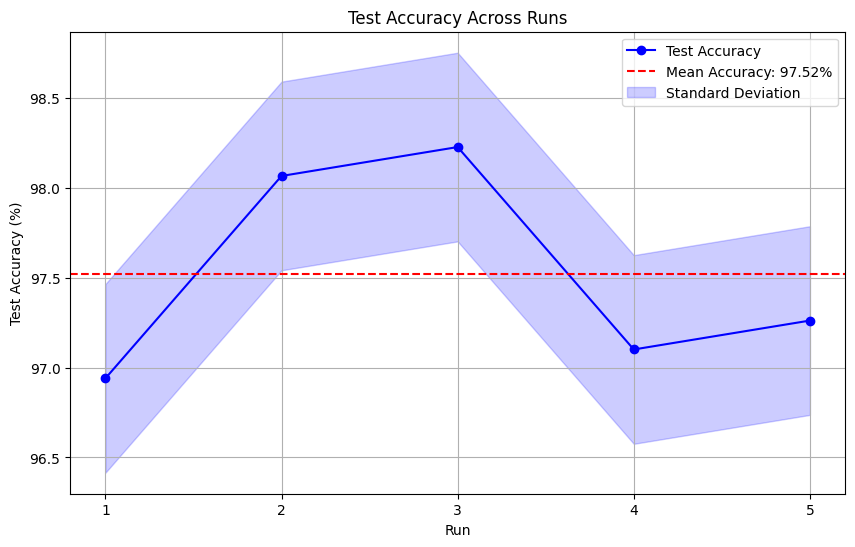

In [13]:
# Line Plot for Loss Curves ---
plt.figure(figsize=(10, 6))
for run, (train_loss_history, val_loss_history) in enumerate(history_list, 1):
    plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label=f"Train Loss - Run {run}", linestyle='--', alpha=0.7)
    plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label=f"Val Loss - Run {run}", linestyle='-', alpha=0.7)

plt.title("Training and Validation Loss Across All Runs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("loss_curves_all_runs_line_plot.png")
plt.show()

# --- Line Plot for Test Accuracy ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_runs + 1), results, marker='o', color='b', label='Test Accuracy')
plt.axhline(y=mean_accuracy, color='r', linestyle='--', label=f"Mean Accuracy: {mean_accuracy:.2f}%")
plt.fill_between(range(1, num_runs + 1),
                 np.array(results) - std_deviation,
                 np.array(results) + std_deviation,
                 color='blue', alpha=0.2, label="Standard Deviation")
plt.title("Test Accuracy Across Runs")
plt.xlabel("Run")
plt.ylabel("Test Accuracy (%)")
plt.xticks(range(1, num_runs + 1))
plt.legend()
plt.grid(True)
plt.savefig("test_accuracy_line_plot.png")
plt.show()


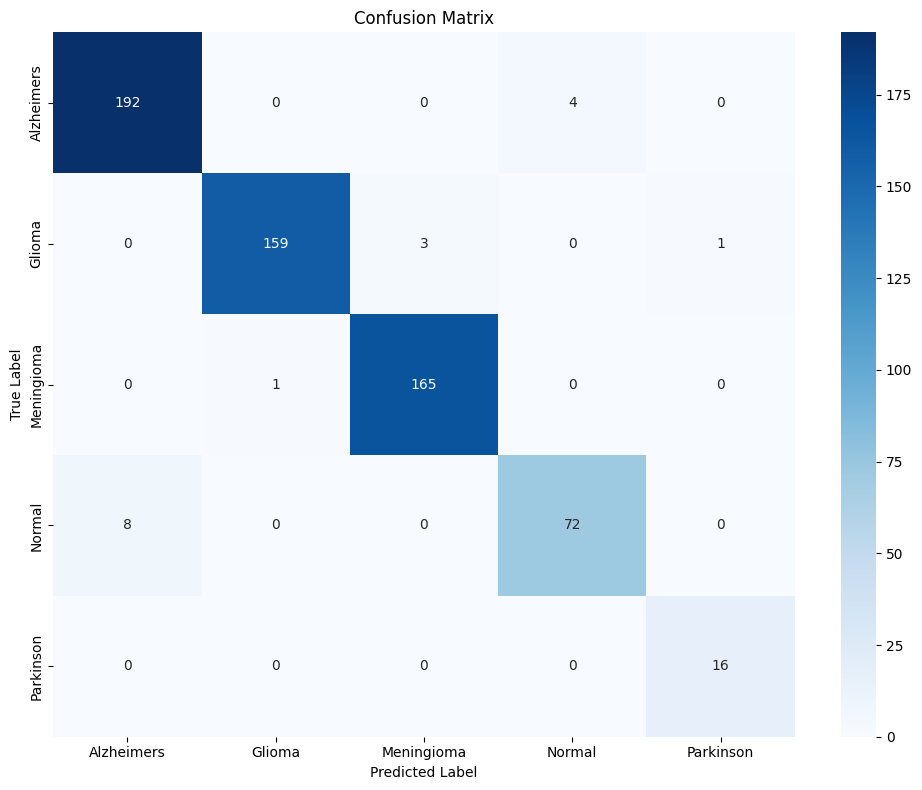

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import torch

# ... (Your training loop and model loading code) ...

# --- Generate Confusion Matrix ---

# Set model to evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Collect predictions and true labels for the test set
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# --- Plot Confusion Matrix ---

# Get class names
class_names = datasets_dict['test'].classes

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

# Customize the plot
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()

# Save and show the plot
plt.savefig("confusion_matrix.png")
plt.show()

<ipython-input-15-a003e0fc810d>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"googlenet_run_{best_run}.pth"))


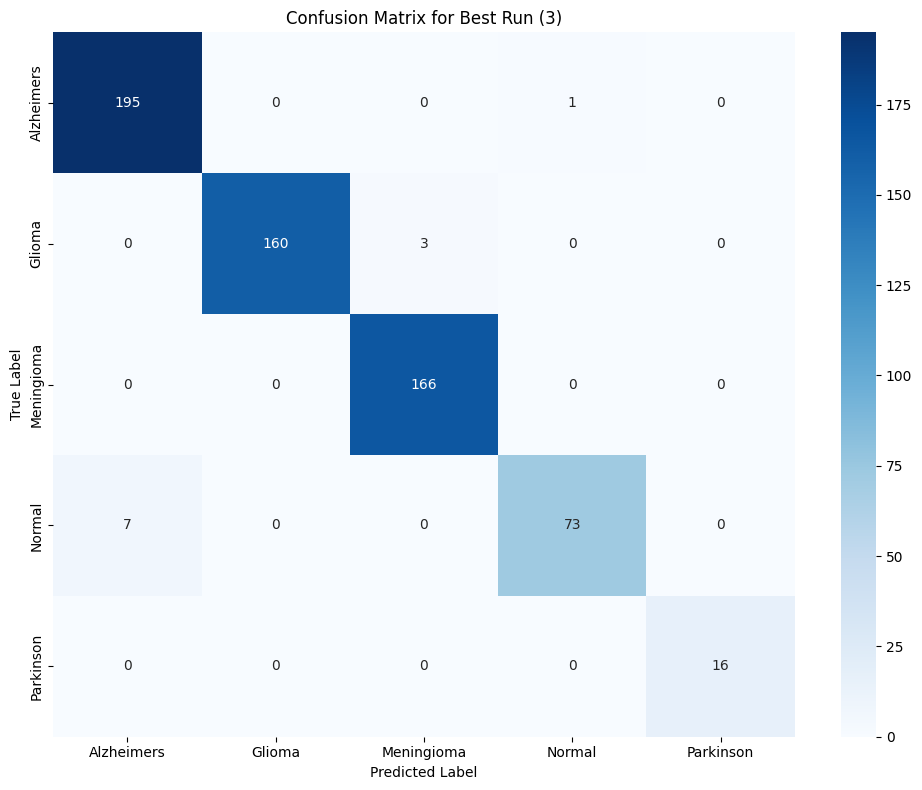

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import torch

# ... (Your training loop code, including results and num_runs) ...

# --- Load Best Model ---

# Find the run with the best accuracy
best_run_index = np.argmax(results)  # Get index of the highest accuracy
best_run = best_run_index + 1  # Run number starts from 1

# Load the weights of the best model
model.load_state_dict(torch.load(f"googlenet_run_{best_run}.pth"))

# --- Generate Confusion Matrix for Best Model ---

# Set model to evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Collect predictions and true labels for the test set
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# --- Plot Confusion Matrix ---

# Get class names
class_names = datasets_dict['test'].classes

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

# Customize the plot
plt.title(f"Confusion Matrix for Best Run ({best_run})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()

# Save and show the plot
plt.savefig(f"confusion_matrix_best_run_{best_run}.png")
plt.show()

In [16]:
#to verify number of images in test set
print(len(datasets_dict['test'].targets))  # Total number of images in the test set
print(datasets_dict['test'].targets.count(datasets_dict['test'].class_to_idx['Normal']))  # Number of Normal images in the test set
print(datasets_dict['test'].targets.count(datasets_dict['test'].class_to_idx['Alzheimers']))  # Number of Alz images in the test set
print(datasets_dict['test'].targets.count(datasets_dict['test'].class_to_idx['Glioma']))  # Number of Glioma images in the test set
print(datasets_dict['test'].targets.count(datasets_dict['test'].class_to_idx['Meningioma']))  # Number of Meningioma images in the test set
print(datasets_dict['test'].targets.count(datasets_dict['test'].class_to_idx['Parkinson']))  # Number of Parkinson images in the test set

621
80
196
163
166
16


In [17]:
# Total number of images in the train set
print("Total images in train set:", len(datasets_dict['train'].targets))

# Number of Normal images in the train set
print("Normal images in train set:", datasets_dict['train'].targets.count(datasets_dict['train'].class_to_idx['Normal']))
print("Alzheimers images in train set:", datasets_dict['train'].targets.count(datasets_dict['train'].class_to_idx['Alzheimers']))
print("Glioma images in train set:", datasets_dict['train'].targets.count(datasets_dict['train'].class_to_idx['Glioma']))
print("Meningioma images in train set:", datasets_dict['train'].targets.count(datasets_dict['train'].class_to_idx['Meningioma']))
print("Parkinson images in train set:", datasets_dict['train'].targets.count(datasets_dict['train'].class_to_idx['Parkinson']))

Total images in train set: 4952
Normal images in train set: 640
Alzheimers images in train set: 1568
Glioma images in train set: 1296
Meningioma images in train set: 1324
Parkinson images in train set: 124


In [18]:
# Total number of images in the validation set
print("Total images in validation set:", len(datasets_dict['val'].targets))

# Number of Normal images in the validation set
print("Normal images in validation set:", datasets_dict['val'].targets.count(datasets_dict['val'].class_to_idx['Normal']))
print("Alzheimers images in validation set:", datasets_dict['val'].targets.count(datasets_dict['val'].class_to_idx['Alzheimers']))
print("Glioma images in validation set:", datasets_dict['val'].targets.count(datasets_dict['val'].class_to_idx['Glioma']))
print("Meningioma images in validation set:", datasets_dict['val'].targets.count(datasets_dict['val'].class_to_idx['Meningioma']))
print("Parkinson images in validation set:", datasets_dict['val'].targets.count(datasets_dict['val'].class_to_idx['Parkinson']))

Total images in validation set: 619
Normal images in validation set: 80
Alzheimers images in validation set: 196
Glioma images in validation set: 162
Meningioma images in validation set: 165
Parkinson images in validation set: 16


In [19]:
import torch
torch.save(model.state_dict(), '/content/drive/My Drive/GN82.pth')